## Seminary 1
By Dimitar Djorlev (63220409), Žane Bučan (63220036)

In [20]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import json

In this seminar we were given a task to create a genetic algorithm to develop a smart and efficient system for assigning conference papers to reviewers. The problem was, that some reviewers were friends so they should not review each others' papers and some had preferences on which paper they want to review. Each paper also had minimum number of reviews that it needs and every reviewer had a maximum number of papers that he can review and of course each author can not review his own paper. We needed to consider these constraints and find the best solution to this problem.

The seminar included four tasks:

### Task 1: Representation
In this task we needed to convert .json files into a representative way, so that the algorithm could understand them. That is why we transformed those files into different matrices.


In [21]:
def load_data(json_file_path):
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    return data

def parse_json(data):
    N = data["num_papers"]
    K = data["num_reviewers"]
    R = data["reviewer_capacity"]
    min_reviews_per_paper = data["min_reviews_per_paper"]
    max_reviews_per_paper = data["max_reviews_per_paper"]
    
    preference_matrix = np.array(data["preferences"])             ### make all the matrices as ... matrices ofc
    friendship_matrix = np.array(data["friendships"])
    authorship_matrix = np.array(data["authorship"])
    
    return (N, K, R, min_reviews_per_paper, max_reviews_per_paper,
            preference_matrix, friendship_matrix, authorship_matrix)

Next step was to create a fitness fuction, to determine which solution is the best for our problem. It determens the quality of the solution represented by each individual, giving it a grade (fitnes score), which guides the algorithm to select better solutions for the next generation.

In [2]:
def fitness_function(assignment, preference_matrix, friendship_matrix, authorship_matrix,
                     capacity, min_reviews_per_paper, max_reviews_per_paper):
    
    fitness = np.sum(assignment * preference_matrix)
    penalty = 0

    for j in range(assignment.shape[0]):
        reviews_assigned = assignment[j, :].sum()
        if reviews_assigned > capacity:
            penalty += (reviews_assigned - capacity) * 2

    for i in range(assignment.shape[1]):
        reviews_needed = assignment[:, i].sum()
        if reviews_needed < min_reviews_per_paper:
            penalty += (min_reviews_per_paper - reviews_needed) * 2
        elif reviews_needed > max_reviews_per_paper:
            penalty += (reviews_needed - max_reviews_per_paper) * 2

    for i in range(assignment.shape[0]):
        for j in range(assignment.shape[1]):
            if assignment[i, j] == 1:
                for k in range(authorship_matrix[:, j].shape[0]):
                    if authorship_matrix[k, j] == 1 and friendship_matrix[i, k] == 1:
                        penalty += 5
              
    penalty += np.sum(assignment * authorship_matrix) * 6
    return fitness - penalty

The final part of **Task 1** was to create an generic algorithm. Creating one includes more steps.
- Step 1: Create a function that would generate a random assignment. This creates a binary matric (num_papers x num_reviewers) which defines if a reviewer reviews a paper (1) or not (0).

In [23]:
def generate_random_assignment(num_papers, num_reviewers, reviewer_capacity,
                               min_reviews_per_paper, max_reviews_per_paper):
    
    assignment = np.zeros((num_reviewers, num_papers), dtype=int)
    
    for i in range(num_papers):
        reviewers = np.random.choice(range(num_reviewers), 
                                     size=np.random.randint(min_reviews_per_paper, max_reviews_per_paper + 1), 
                                     replace=False)
        assignment[reviewers, i] = 1
    
    for j in range(num_reviewers):
        while assignment[j, :].sum() > reviewer_capacity:
            assigned_papers = np.where(assignment[j, :] == 1)[0]
            paper_to_remove = np.random.choice(assigned_papers)
            assignment[j, paper_to_remove] = 0

    return assignment

- Step 2: Initialize a population of these assignments to test them in our algorithm.

In [24]:
def initialize_population(pop_size, N, K, R, min_reviews, max_reviews):                                #### generate the first population
    return [generate_random_assignment(N, K, R, min_reviews, max_reviews) for _ in range(pop_size)]

- Step 3: Create functions, which are a crucial to creating a good genercic algorithm.

In [25]:
import random

Mutation: \
Mutation is a function that introduces variability to help the algorithm explore more solutions. It achieves that by changing a random gene (a value in the matric). This helps the algorithm avoid permature convergence on local optima by maintainig exploration capability in the search space.

In [26]:
def mutate(assignment, R, min_reviews, max_reviews):                             #### mutate by flipping a random entry 0->1 or 1->0
    num_rev, num_pap = assignment.shape
    num_mutates = random.randint(1, 5)
    for n in range(num_mutates):
        i, j = random.randint(0, num_rev - 1), random.randint(0, num_pap - 1)
        assignment[i, j] = 1 - assignment[i, j]  
    
        if assignment[i, :].sum() > R:
            assignment[i, j] = 0
        if assignment[i, :].sum() < min_reviews:
            assignment[i, j] = 1
        elif assignment[i, :].sum() > max_reviews:
            assignment[i, j] = 0
    return assignment

def mutate_swap(assignment, R, min_reviews, max_reviews):
    num_rev, num_pap = assignment.shape
    i, j = random.randint(0, num_rev - 1), random.randint(0, num_pap - 1)
    k, l = random.randint(0, num_rev - 1), random.randint(0, num_pap - 1)
    
    assignment[i, j], assignment[k, l] = assignment[k, l], assignment[i, j]
    
    if assignment[i, :].sum() > R:
        assignment[i, j] = 0
    if assignment[i, :].sum() < min_reviews:
        assignment[i, j] = 1
    elif assignment[i, :].sum() > max_reviews:
        assignment[i, j] = 0
    
    if assignment[k, :].sum() > R:
        assignment[k, l] = 0
    if assignment[k, :].sum() < min_reviews:
        assignment[k, l] = 1
    elif assignment[k, :].sum() > max_reviews:
        assignment[k, l] = 0
    
    return assignment

def mutate_scramble(assignment, R, min_reviews, max_reviews):
    num_rev, num_pap = assignment.shape
    i = random.randint(0, num_rev - 1)
    start, end = sorted(random.sample(range(num_pap), 2))
    
    np.random.shuffle(assignment[i, start:end+1])
    
    if assignment[i, :].sum() > R:
        for j in range(start, end+1):
            if assignment[i, j] == 1:
                assignment[i, j] = 0
                if assignment[i, :].sum() <= R:
                    break
    if assignment[i, :].sum() < min_reviews:
        for j in range(start, end+1):
            if assignment[i, j] == 0:
                assignment[i, j] = 1
                if assignment[i, :].sum() >= min_reviews:
                    break
    elif assignment[i, :].sum() > max_reviews:
        for j in range(start, end+1):
            if assignment[i, j] == 1:
                assignment[i, j] = 0
                if assignment[i, :].sum() <= max_reviews:
                    break
    
    return assignment

def mutate_inversion(assignment, R, min_reviews, max_reviews):
    num_rev, num_pap = assignment.shape
    i = random.randint(0, num_rev - 1)
    start, end = sorted(random.sample(range(num_pap), 2))
    
    assignment[i, start:end+1] = assignment[i, start:end+1][::-1]
    
    if assignment[i, :].sum() > R:
        for j in range(start, end+1):
            if assignment[i, j] == 1:
                assignment[i, j] = 0
                if assignment[i, :].sum() <= R:
                    break
    if assignment[i, :].sum() < min_reviews:
        for j in range(start, end+1):
            if assignment[i, j] == 0:
                assignment[i, j] = 1
                if assignment[i, :].sum() >= min_reviews:
                    break
    elif assignment[i, :].sum() > max_reviews:
        for j in range(start, end+1):
            if assignment[i, j] == 1:
                assignment[i, j] = 0
                if assignment[i, :].sum() <= max_reviews:
                    break
    
    return assignment

Crossover: \
A crossover function takes two individuals from the population called parents. It takes some part of information from one parent and swaps it with the information of the second parent. With this we acheive new individuals called children, who lead the algorithm to exploit better traits from multiple solutions from the population.

In [27]:
def crossover_one_point(parent1, parent2):
    num_rev, num_pap = parent1.shape
    crossover_point = random.randint(0, num_rev - 1)
    child1 = np.vstack((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.vstack((parent2[:crossover_point], parent1[crossover_point:]))
    return child1, child2

def crossover_two_point(parent1, parent2):
    num_rev, num_pap = parent1.shape
    point1, point2 = sorted(random.sample(range(num_rev), 2))
    child1 = np.vstack((parent1[:point1], parent2[point1:point2], parent1[point2:]))
    child2 = np.vstack((parent2[:point1], parent1[point1:point2], parent2[point2:]))
    return child1, child2

def crossover_uniform(parent1, parent2):
    num_rev, num_pap = parent1.shape
    child1, child2 = np.zeros_like(parent1), np.zeros_like(parent2)
    for i in range(num_rev):
        if random.random() > 0.5:
            child1[i, :], child2[i, :] = parent1[i, :], parent2[i, :]
        else:
            child1[i, :], child2[i, :] = parent2[i, :], parent1[i, :]
    return child1, child2

Selection: \
Selection is a part of the genetic algorithm, which defines who from the population will be used to create the next generation. It ensures that the better solutions (those with higher fitness) are more likely to be chosen to pass their information to the next generation.

In [28]:
def proportional_selection(population, fitness_scores):
    fitness_sum = sum(fitness_scores)
    probabilities = [score / fitness_sum for score in fitness_scores]
    parents = random.choices(population, weights=probabilities, k=2)
    return parents

def rank_based_selection(population, fitness_scores):
    ranks = np.argsort(np.argsort(fitness_scores)) + 1
    total_rank = np.sum(ranks)
    
    probabilities = ranks / total_rank
    parents = random.choices(population, weights=probabilities, k=2)
    
    return parents

def tournament_selection(population, fitness_scores, tournament_size=10):
    selected = random.sample(list(zip(population, fitness_scores)), tournament_size)
    selected.sort(key=lambda x: x[1], reverse=True)
    return selected[0][0], selected[1][0]

Functions which define what type of crossover/mutation/selection we will use:

In [29]:
def select_parents(population, fitness_scores, selection_method='proportional'):
    if selection_method == 'proportional':
        return proportional_selection(population, fitness_scores)
    elif selection_method == 'rank-based':
        return rank_based_selection(population, fitness_scores)
    elif selection_method == 'tournament':
        return tournament_selection(population, fitness_scores)
    else:
        raise ValueError("Invalid selection method")
    
def select_crossover(crossover_method, parent1, parent2):
    if crossover_method == 'one-point':
        return crossover_one_point(parent1, parent2)
    elif crossover_method == 'two-point':
        return crossover_two_point(parent1, parent2)
    elif crossover_method == 'uniform':
        return crossover_uniform(parent1, parent2)
    else:
        raise ValueError("Invalid crossover method")
    
def select_mutation(mutation_method, child, R, min_reviews, max_reviews):
    if mutation_method == 'random':
        return mutate(child, R, min_reviews, max_reviews)
    elif mutation_method == 'swap':
        return mutate_swap(child, R, min_reviews, max_reviews)
    elif mutation_method == 'scramble':
        return mutate_scramble(child, R, min_reviews, max_reviews)
    elif mutation_method == 'inversion':
        return mutate_inversion(child, R, min_reviews, max_reviews)
    else:
        raise ValueError("Invalid mutation method")

And of course the algorithm itself:

In [30]:
def genetic_algorithm(num_papers, num_reviewers, reviewer_capacity, min_reviews, max_reviews, preference_matrix, friendship_matrix, authorship_matrix, generations=100, pop_size=20, 
                      parents_mating=2, selection_method='proportional', crossover_method='one-point', mutation_method='scramble'):
    population = initialize_population(pop_size, num_papers, num_reviewers, reviewer_capacity, min_reviews, max_reviews)
    best_fitness_scores = []
    
    for generation in range(generations):
        fitness_scores = [fitness_function(ind, preference_matrix, friendship_matrix, authorship_matrix, reviewer_capacity, min_reviews, max_reviews) for ind in population]
        new_population = []
        
        while len(new_population) < pop_size:
            parent1, parent2 = select_parents(population, fitness_scores, selection_method)
            
            child1, child2 = select_crossover(crossover_method, parent1, parent2)
            
            child1 = select_mutation(mutation_method, child1, reviewer_capacity, min_reviews, max_reviews)
            child2 = select_mutation(mutation_method, child2, reviewer_capacity, min_reviews, max_reviews)
            
            new_population.extend([child1, child2])
        
        population = new_population[:pop_size]
        best_fitness = max(fitness_scores)
        best_fitness_scores.append(best_fitness)
        # print(f"Generation {generation + 1}: Best Fitness = {best_fitness}")

    best_index = np.argmax(fitness_scores)
    return population[best_index], best_fitness_scores, population


These are the results of our algorithm:

The best is:  [[0 0 1 1 1 0 0 0 1 0 0 0 0 0 1]
 [1 0 0 0 0 1 0 0 1 0 0 1 0 1 0]
 [0 0 1 1 1 1 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 1 0 1 0 0 0 1]
 [0 1 0 0 0 0 1 1 0 1 0 0 1 0 0]
 [0 0 0 1 1 0 0 1 0 0 1 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 1 0 0 1 1 0]
 [1 0 0 0 0 0 1 1 0 0 0 1 1 0 0]
 [0 0 0 0 0 1 0 0 0 1 1 0 0 1 1]
 [0 1 0 0 0 0 1 1 0 0 0 1 0 1 0]]


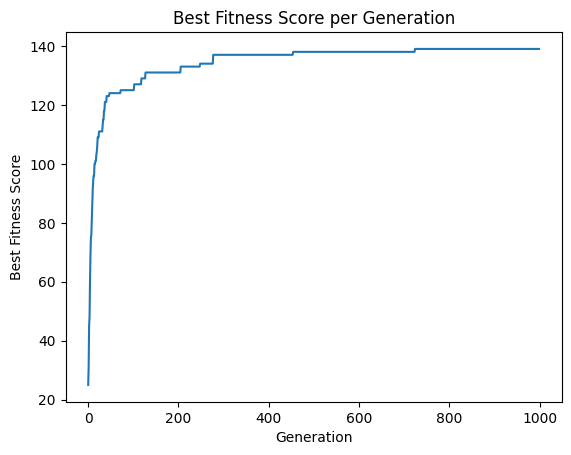

In [31]:
json_file_path = 'datasets/hard_dataset_1.json'     ### change the dataset if needed

data = load_data(json_file_path)
(N, K, R, min_reviews_per_paper, max_reviews_per_paper,
    preference_matrix, friendship_matrix, authorship_matrix) = parse_json(data)

best_assignment, fitness_scores, population = genetic_algorithm(
    num_papers=N, 
    num_reviewers=K, 
    reviewer_capacity=R, 
    min_reviews=min_reviews_per_paper, 
    max_reviews=max_reviews_per_paper, 
    preference_matrix=preference_matrix,
    friendship_matrix=friendship_matrix,
    authorship_matrix=authorship_matrix,
    generations=1000,
    pop_size=50,
    parents_mating = 2,
    selection_method='tournament',
    crossover_method='one-point',
    mutation_method='swap'
)

print("The best is: ", best_assignment)

#### Plot the fitness scores
plt.plot(fitness_scores)
plt.xlabel('Generation')
plt.ylabel('Best Fitness Score')
plt.title('Best Fitness Score per Generation')
plt.show()


##### Test the first functions
# print(parse_json(data))
# assignment = generate_random_assignment(N, K, R, min_reviews_per_paper, max_reviews_per_paper)
# fitness_score = fitness_function(assignment, preference_matrix, friendship_matrix, 
#                                 authorship_matrix, R, min_reviews_per_paper, max_reviews_per_paper)       
# print(assignment)
# print("Score: ", fitness_score)

### Task 2: Crossover and Mutation
In this task, we needed to upgrade our algorith and our functions to include them in an existing genetic algorithm using PyGad. We still had to be carefull of the constraints each reviewer and paper has, to insure the algorihm creates valid solutions.

In [32]:
import pygad
import time

We redefined the function which inializes the population, so that it would be in a format that is acceptable by pygad

In [33]:
def initialize_population_pygad(pop_size, N, K, R, min_reviews, max_reviews):                                #### generate the first population
    population = [
        generate_random_assignment(N, K, R, min_reviews, max_reviews).flatten()
        for _ in range(pop_size)
        ]
    return np.array(population)

We combined each function of the algorithm inside a class called GA_utils, to safely store the data which is used in the algorithm and use it as 'global'.

In [1]:
class GA_utils:
    def __init__(self, preference_matrix, friendship_matrix, authorship_matrix, capacity, min_reviews_per_paper, max_reviews_per_paper):
        self.preference_matrix = preference_matrix
        self.friendship_matrix = friendship_matrix
        self.authorship_matrix = authorship_matrix
        self.capacity = capacity
        self.min_reviews_per_paper = min_reviews_per_paper
        self.max_reviews_per_paper = max_reviews_per_paper
        self.num_genes = preference_matrix.shape[0] * preference_matrix.shape[1]
        self.population = None

    def fitness_function(self, ga_instance, solution, solution_idx):
        assignment = solution.reshape(self.preference_matrix.shape)

        fitness = np.sum(assignment * self.preference_matrix)
        penalty = 0

        for j in range(assignment.shape[0]):
            reviews_assigned = assignment[j, :].sum()
            if reviews_assigned > self.capacity:
                penalty += (reviews_assigned - self.capacity) * 2

        for i in range(assignment.shape[1]):
            reviews_needed = assignment[:, i].sum()
            if reviews_needed < self.min_reviews_per_paper:
                penalty += (self.min_reviews_per_paper - reviews_needed) * 2
            elif reviews_needed > self.max_reviews_per_paper:
                penalty += (reviews_needed - self.max_reviews_per_paper) * 2

        for i in range(assignment.shape[0]):
            for j in range(assignment.shape[1]):
                if assignment[i, j] == 1:
                    for k in range(self.authorship_matrix[:, j].shape[0]):
                        if self.authorship_matrix[k, j] == 1 and self.friendship_matrix[i, k] == 1:
                            penalty += 5

        penalty += np.sum(assignment * self.authorship_matrix) * 6

        return fitness - penalty

    def crossover_one_point(self, parents, offspring_size, ga_instance):
        offspring = []
        crossover_point = np.random.randint(1, parents.shape[1]) 

        for k in range(offspring_size[0]): 
            parent1_idx = k % parents.shape[0]
            parent2_idx = (k + 1) % parents.shape[0]

            parent1 = parents[parent1_idx]
            parent2 = parents[parent2_idx]

            child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            offspring.append(child)

        return np.array(offspring)

    def crossover_two_point(self, parents, offspring_size, ga_instance):
        offspring = []
        crossover_point1 = np.random.randint(1, parents.shape[1] - 1)
        crossover_point2 = np.random.randint(crossover_point1 + 1, parents.shape[1])

        for k in range(offspring_size[0]):
            parent1_idx = k % parents.shape[0]
            parent2_idx = (k + 1) % parents.shape[0]

            parent1 = parents[parent1_idx]
            parent2 = parents[parent2_idx]

            child = np.concatenate((parent1[:crossover_point1], parent2[crossover_point1:crossover_point2], parent1[crossover_point2:]))
            offspring.append(child)

        return np.array(offspring)

    def crossover_uniform(self, parents, offspring_size, ga_instance):
        offspring = []
        for k in range(offspring_size[0]):
            parent1_idx = k % parents.shape[0]
            parent2_idx = (k + 1) % parents.shape[0]

            parent1 = parents[parent1_idx]
            parent2 = parents[parent2_idx]

            child = np.zeros(parents.shape[1])
            for gene_idx in range(parents.shape[1]):
                if np.random.rand() < 0.5:
                    child[gene_idx] = parent1[gene_idx]
                else:
                    child[gene_idx] = parent2[gene_idx]
            offspring.append(child)

        return np.array(offspring)
    
    def mutate_flip(self, offspring, ga_instance):
        for idx in range(offspring.shape[0]):
            mutation_indices = np.random.choice(range(offspring.shape[1]), size=int(0.1 * offspring.shape[1]), replace=False)
            for gene_idx in mutation_indices:
                offspring[idx, gene_idx] = 1 - offspring[idx, gene_idx]
        return offspring

    def mutate_swap(self, offspring, ga_instance):
        for idx in range(offspring.shape[0]):
            swap_indices = np.random.choice(range(offspring.shape[1]), size=2, replace=False)
            offspring[idx, swap_indices[0]], offspring[idx, swap_indices[1]] = offspring[idx, swap_indices[1]], offspring[idx, swap_indices[0]]
        return offspring

    def mutate_inversion(self, offspring, ga_instance):
        for idx in range(offspring.shape[0]):
            start, end = sorted(np.random.choice(range(offspring.shape[1]), size=2, replace=False))
            offspring[idx, start:end] = offspring[idx, start:end][::-1]
        return offspring
    
    def mutate_scramble(self, offspring, ga_instance):
        num_rev, num_pap = offspring.shape
        for id in range(offspring.shape[0]):
            start, end = sorted(np.random.choice(range(num_pap), size=2, replace=False))
            np.random.shuffle(offspring[id, start:end])
        return offspring

    def proportional_selection(self, fitness, num_parents, ga_instance):
        fitness_sum = np.sum(fitness)
        selection_probs = fitness / fitness_sum
        selected_parents = random.choices(population=ga_instance.population, k=2, weights=selection_probs)
        return selected_parents
    
    def proportional_selection_w_indices(self, fitness, num_parents, ga_instance):
        fitness_sum = np.sum(fitness)
        selection_probs = fitness / fitness_sum
        selected_indices = random.choices(range(len(ga_instance.population)), k=2, weights=selection_probs)
        selected_parents = ga_instance.population[selected_indices]
        #print(selected_parents)
        return selected_parents

    def rank_based_selection(self, fitness, num_parents, ga_instance):
        sorted_indices = np.argsort(fitness) 
        ranks = np.argsort(sorted_indices) + 1  
        selection_probs = ranks / np.sum(ranks)
        selected_indices = np.random.choice(range(len(ga_instance.population)), size=num_parents, p=selection_probs)
        selected_parents = ga_instance.population[selected_indices]
        return selected_parents

    def tournament_selection(self, fitness, num_parents, ga_instance, tournament_size=3):
        selected_parents = []
        for _ in range(num_parents):
            tournament_indices = np.random.choice(range(len(ga_instance.population)), size=tournament_size, replace=False)
            tournament_fitness = fitness[tournament_indices]
            winner_idx = tournament_indices[np.argmax(tournament_fitness)]
            selected_parents.append(ga_instance.population[winner_idx])
        return np.array(selected_parents)


And this are the results of the pygad genetic algorithm.

c:\Python312\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


[0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0.
 0. 0. 1. 0. 1. 0.]
158.0


c:\Python312\Lib\site-packages\pygad\visualize\plot.py:109: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplotlib.pyplot.legend()


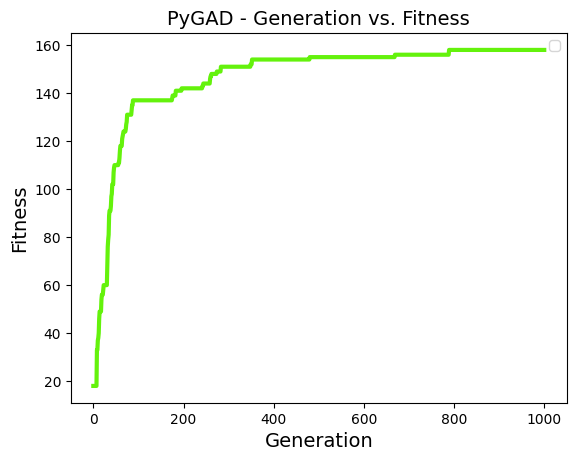

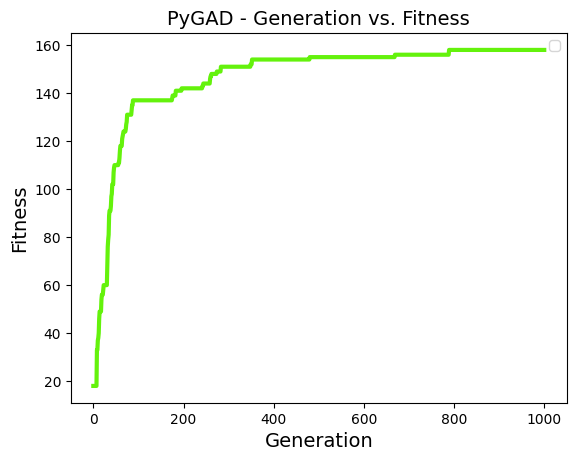

In [ ]:
json_file_path = 'datasets/hard_dataset_1.json'     ### change the dataset if needed

data = load_data(json_file_path)
(N, K, R, min_reviews_per_paper, max_reviews_per_paper,
    preference_matrix, friendship_matrix, authorship_matrix) = parse_json(data)

pop_size = 100
initial_pop = initialize_population_pygad(pop_size, N, K, R, min_reviews_per_paper, max_reviews_per_paper)

myEnv = GA_utils(preference_matrix, friendship_matrix, authorship_matrix, R, min_reviews_per_paper, max_reviews_per_paper)

ga_instance = pygad.GA(
        num_parents_mating=2, 
        num_generations=1000,
        sol_per_pop=20,
        mutation_probability=0.1,
        num_genes=N * K,              
        gene_space=[0, 1],      
        initial_population=initial_pop,
        fitness_func=myEnv.fitness_function,
        crossover_type=myEnv.crossover_one_point,
        mutation_type=myEnv.mutate_swap,
        parent_selection_type="tournament"
)
ga_instance.run()

solution, fitness, solution_idx = ga_instance.best_solution()

print(solution)
print(fitness)
ga_instance.plot_fitness()

### Task 3: Complexity and Diversity

The aim of this task was to motivate us to create a genetic algotitm to handle complex assignment scenatios by including constrains each reviewer and paper has and encouraging us to create multiple genetic operators (mutation, selection, crossover). By penalizing solutions, which do not include these constraints, we ensured balance between efficient solutions while allowing the algorithm to explore wide solution space. This will lead to more feasible, efficient and diverse solutions.

### Task 4: Evaluation
The main goal of this task was to represent the results of our algorithm. To acheive that, we made various graphs to represent each setup of the algorithm.

#### First we were intrested in the run time of the algorithm and the fitness scores.

We included three configurations:
- selection method: **torurnament**, crossover method: **one-point**, mutation method: **swap**
- selection method: **ranked-based**, crossover method: **two-point**, mutation method: **scramble**
- selection method: **tournament**, crossover method: **uniform**, mutation method: **inversion**

We tested each configuration on eight datasets, which are split in three categories (easy, medium, hard).

This is the setup:

In [53]:
import time
dataset_paths = ['datasets/easy_dataset_1.json','datasets/easy_dataset_2.json',
                 'datasets/medium_dataset_1.json','datasets/medium_dataset_2.json',
                 'datasets/hard_dataset_1.json','datasets/hard_dataset_2.json','datasets/hard_dataset_3.json', 'datasets/hard_dataset_4.json']

def load_and_parse_data(file_path):
    data = load_data(file_path)
    return parse_json(data)

results = []

configurations = [
    ('tournament', 'one-point', 'swap'),
    ('rank-based', 'two-point', 'scramble'),
    ('tournament', 'uniform', 'inversion')
]

for dataset_path in dataset_paths:
    N, K, R, min_reviews, max_reviews, preference_matrix, friendship_matrix, authorship_matrix = load_and_parse_data(dataset_path)
    
    for selection_method, crossover_method, mutation_method in configurations:
        print(f"Evaluating configuration: {selection_method}, {crossover_method}, {mutation_method}")
        
        start_time = time.time()
        best_assignment, fitness_scores, _ = genetic_algorithm(
            num_papers=N, 
            num_reviewers=K, 
            reviewer_capacity=R, 
            min_reviews=min_reviews, 
            max_reviews=max_reviews, 
            preference_matrix=preference_matrix,
            friendship_matrix=friendship_matrix,
            authorship_matrix=authorship_matrix,
            generations=1000,
            pop_size=20,
            parents_mating=2,
            selection_method=selection_method,
            crossover_method=crossover_method,
            mutation_method=mutation_method
        )
        runtime = time.time() - start_time
        best_fitness = max(fitness_scores)
        
        results.append({
            'dataset': dataset_path,
            'selection_method': selection_method,
            'crossover_method': crossover_method,
            'mutation_method': mutation_method,
            'best_fitness': best_fitness,
            'runtime': runtime
        })
results_df = pd.DataFrame(results)

print(results_df)

# 5. Conclusion and Recommendations
# Discuss which configurations performed best and why, as well as potential trade-offs.

# # Save the notebook or export results to a CSV for further analysis
# results_df.to_csv('evaluation_results.csv', index=False)


Evaluating configuration: tournament, one-point, swap
Evaluating configuration: rank-based, two-point, scramble
Evaluating configuration: tournament, uniform, inversion
Evaluating configuration: tournament, one-point, swap
Evaluating configuration: rank-based, two-point, scramble
Evaluating configuration: tournament, uniform, inversion
Evaluating configuration: tournament, one-point, swap
Evaluating configuration: rank-based, two-point, scramble
Evaluating configuration: tournament, uniform, inversion
Evaluating configuration: tournament, one-point, swap
Evaluating configuration: rank-based, two-point, scramble
Evaluating configuration: tournament, uniform, inversion
Evaluating configuration: tournament, one-point, swap
Evaluating configuration: rank-based, two-point, scramble
Evaluating configuration: tournament, uniform, inversion
Evaluating configuration: tournament, one-point, swap
Evaluating configuration: rank-based, two-point, scramble
Evaluating configuration: tournament, unifo

With the average run time of:

In [54]:
print(results_df['runtime'].mean())

6.279783695936203


And an average best fitness score of:

In [55]:
print(results_df['best_fitness'].mean())

140.04166666666666


Next we wanted to visualize the performance based on the best fitness score of each configuration usig lineplot:

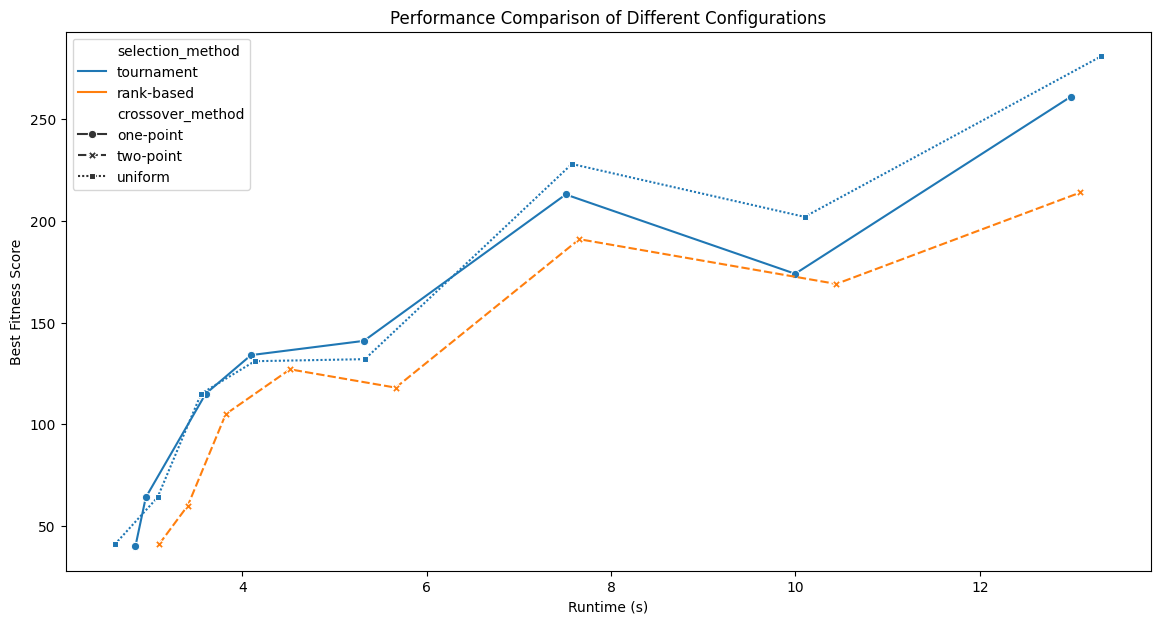

In [56]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=results_df, x='runtime', y='best_fitness', hue='selection_method', style='crossover_method', markers=True)
plt.title('Performance Comparison of Different Configurations')
plt.xlabel('Runtime (s)')
plt.ylabel('Best Fitness Score')
plt.show()

The average scores of each setup are:

In [62]:
for selection, crossover in [('tournament', 'one-point'), ('rank-based', 'two-point'), ('tournament', 'uniform')]:
    print(f"The average score for {selection} selection and {crossover} crossover is {results_df[(results_df['selection_method'] == selection) & (results_df['crossover_method'] == crossover)]['best_fitness'].mean()}")

The average score for tournament selection and one-point crossover is 142.75
The average score for rank-based selection and two-point crossover is 128.125
The average score for tournament selection and uniform crossover is 149.25


Here we can see that the crossover method with the best fitness scores is the **uniform** method with the **tournament** selection method. The worst one is the **two point** crossover method with the **rank based** selection method.

In the next graph, we can see the difference of run time based on the size and difficulty of the data set:

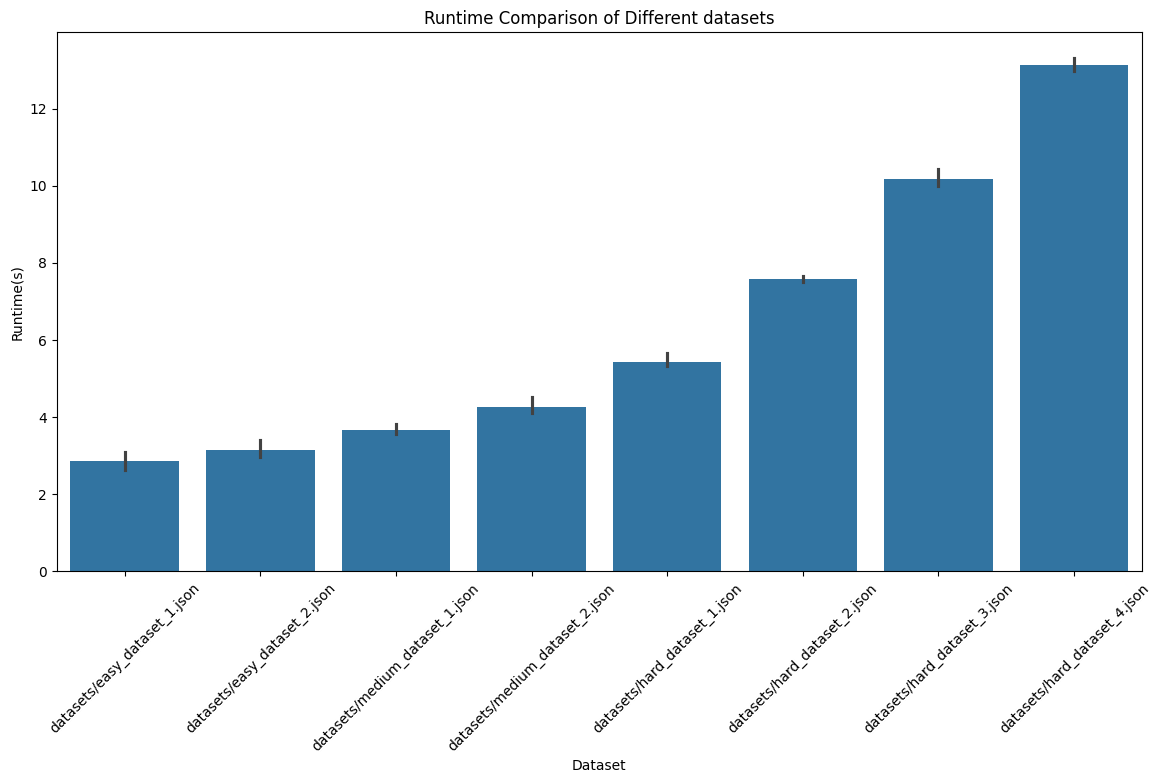

In [57]:
plt.figure(figsize=(14, 7))
sns.barplot(data=results_df, x='dataset', y='runtime')
plt.title('Runtime Comparison of Different datasets')
plt.xlabel('Dataset')
plt.ylabel('Runtime(s)')
plt.xticks(rotation=45)
plt.show()

With the average run time of each group of datasets:

In [64]:
group_size = [6, 6, 12]
means = []
start_idx = 0

for size in group_size:
    means.append(results_df['runtime'].iloc[start_idx:start_idx + size].mean())
    start_idx += size

for group, mean in zip(['easy', 'medium', 'hard'], means):
    print(f"The average fitness score for {group} datasets is {mean}")

The average fitness score for easy datasets is 3.000643491744995
The average fitness score for medium datasets is 3.9544063409169516
The average fitness score for hard datasets is 9.082042475541433


As expected the bigger the data set the slower the algorithm is. This is because it creates bigger agents, with more data to be proccesed, so it is trivial that it needs more time to compute the results.

With the next graph we wanted to visualize the run time analysis based on the crossover method:

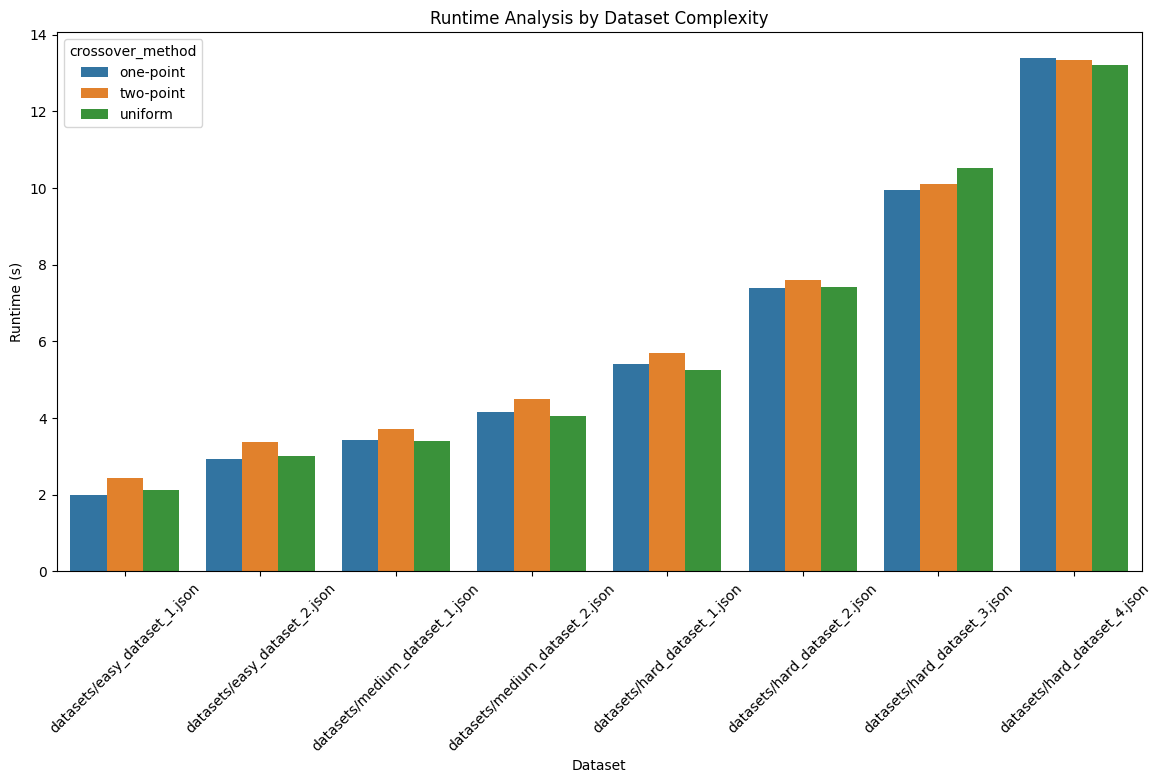

In [40]:
plt.figure(figsize=(14, 7))
sns.barplot(x='dataset', y='runtime', hue='crossover_method', data=results_df)
plt.title('Runtime Analysis by Dataset Complexity')
plt.xlabel('Dataset')
plt.ylabel('Runtime (s)')
plt.xticks(rotation=45)
plt.show()


In [58]:
for method in ['one-point', 'two-point', 'uniform']:
    print(f"The average runtime for Crossover Method {method} is: {results_df[results_df['crossover_method'] == method]['runtime'].mean()}")

The average runtime for Crossover Method one-point is: 6.162654489278793
The average runtime for Crossover Method two-point is: 6.462765008211136
The average runtime for Crossover Method uniform is: 6.21393159031868


On average we can se that the **one point** crossover method preforms the fastest and **two point** being the slowest.

Next up was to visualize the best fitnes score based on the mutation method:

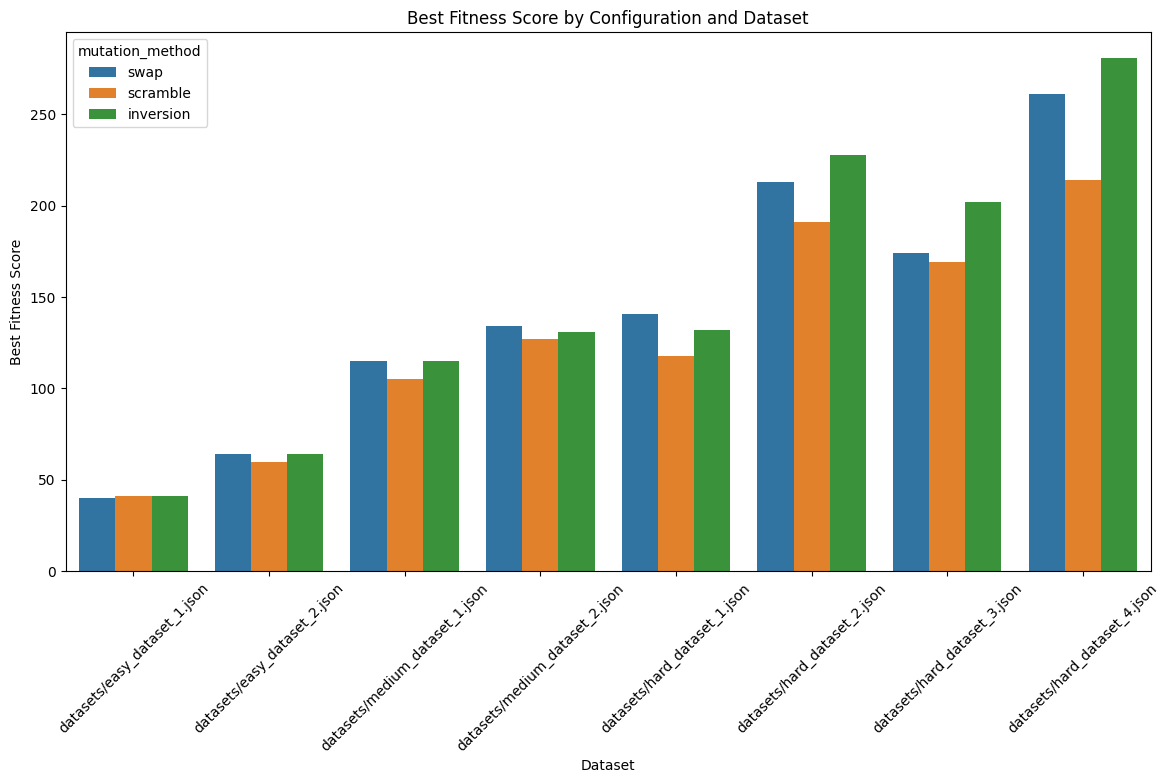

In [60]:

plt.figure(figsize=(14, 7))
sns.barplot(x='dataset', y='best_fitness', hue='mutation_method', data=results_df)
plt.title('Best Fitness Score by Configuration and Dataset')
plt.xlabel('Dataset')
plt.ylabel('Best Fitness Score')
plt.xticks(rotation=45)
plt.show()


In [61]:
for method in ['swap', 'scramble', 'inversion']:
    print(f"The average runtime for Mutation Method {method} is: {results_df[results_df['mutation_method'] == method]['best_fitness'].mean()}")

The average runtime for Mutation Method swap is: 142.75
The average runtime for Mutation Method scramble is: 128.125
The average runtime for Mutation Method inversion is: 149.25


Here we can see that on average the **scrable** mutation method calculates lower fitness scores and the **inversion** mutation method calculates higher fitness scores

#### The next idea of the task was to inspect different agents of the algorithm.
Again we test our algorith on the same eight datasets (easy, medium, hard) and tracked fitness scores of each agent the algorithm produced. 

We used this configuration:
- seletcion method: **torurnament**, crossover method: **one-point**, mutation method: **swap**

This is the setup:

In [42]:
agents = []

for dataset_path in dataset_paths:
    N, K, R, min_reviews, max_reviews, preference_matrix, friendship_matrix, authorship_matrix = load_and_parse_data(dataset_path)
       
    best_assignment, fitness_scores, population = genetic_algorithm(
        num_papers=N, 
        num_reviewers=K, 
        reviewer_capacity=R, 
        min_reviews=min_reviews, 
        max_reviews=max_reviews, 
        preference_matrix=preference_matrix,
        friendship_matrix=friendship_matrix,
        authorship_matrix=authorship_matrix,
        generations=1000,
        pop_size=20,
        parents_mating=2,
        selection_method='tournament',
        crossover_method='one-point',
        mutation_method='swap'
    )
    best_fitness = max(fitness_scores)
        
    agents.append({
        'dataset': dataset_path,
        'best_fitness': best_fitness,
        'agents': population,
        'fitness': [fitness_function(agent, preference_matrix, friendship_matrix, authorship_matrix, R, min_reviews, max_reviews)
                    for agent in population]
    })
agents_df = pd.DataFrame(agents)

print(agents_df)


                          dataset  best_fitness  \
0    datasets/easy_dataset_1.json            41   
1    datasets/easy_dataset_2.json            63   
2  datasets/medium_dataset_1.json           116   
3  datasets/medium_dataset_2.json           133   
4    datasets/hard_dataset_1.json           139   
5    datasets/hard_dataset_2.json           212   
6    datasets/hard_dataset_3.json           186   
7    datasets/hard_dataset_4.json           257   

                                              agents  \
0  [[[0, 1, 0, 1, 1], [1, 0, 1, 1, 0], [1, 0, 1, ...   
1  [[[1, 1, 0, 0, 1, 0], [1, 0, 0, 1, 0, 1], [0, ...   
2  [[[0, 1, 1, 0, 1, 1, 0, 0, 1, 0], [0, 1, 1, 1,...   
3  [[[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1], [1, 1,...   
4  [[[0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1...   
5  [[[0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0...   
6  [[[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
7  [[[0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0...   

                                   

Here we decided to use the scatter method to show each fitness of an agent in dfferent datasets:

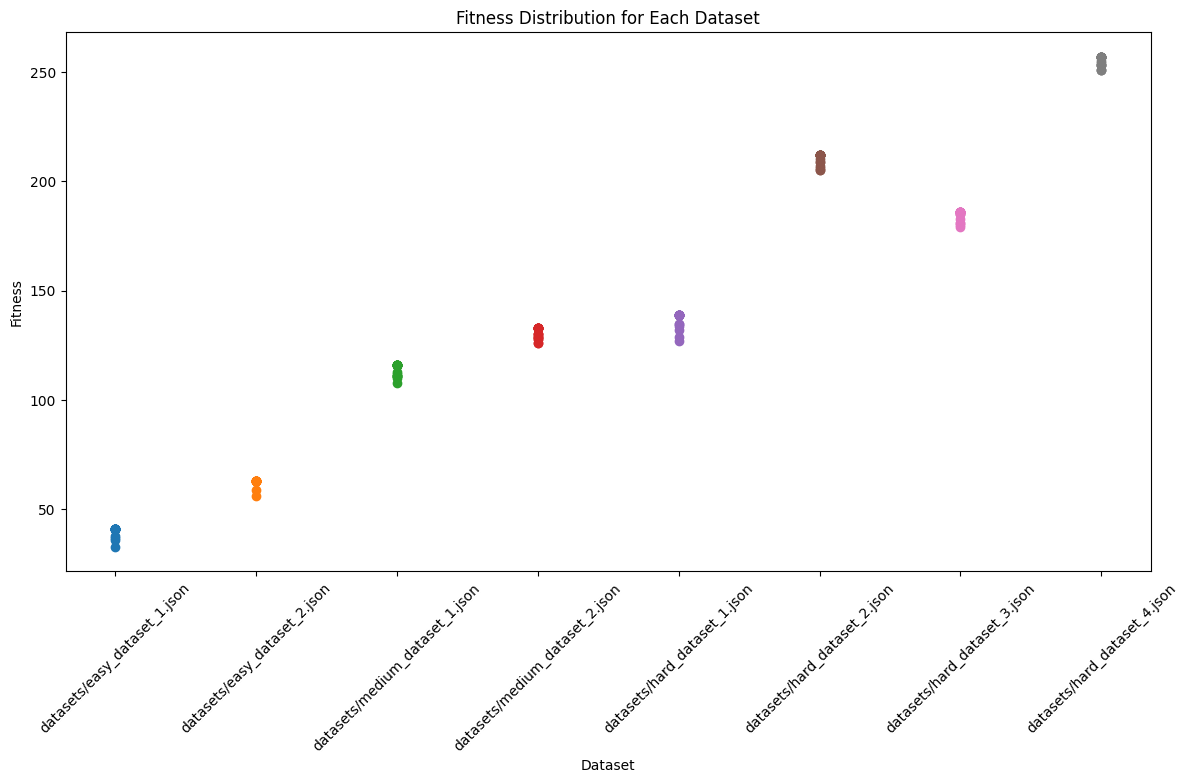

In [43]:
plt.figure(figsize=(14, 7))

for index, row in agents_df.iterrows():
    dataset = row['dataset']
    fitness_values = row['fitness']
    plt.scatter([dataset] * len(fitness_values), fitness_values, label=dataset)

plt.xlabel('Dataset')
plt.ylabel('Fitness')
plt.title('Fitness Distribution for Each Dataset')
plt.xticks(rotation=45)
plt.show()

Each dataset had an average fitness of:

In [74]:
def mean_of_agents(list):
    return np.mean(list)

avg_df = pd.DataFrame({
    'dataset' : agents_df['dataset'],
    'average_fitness' : agents_df['fitness'].apply(mean_of_agents)
})

print(avg_df)

                          dataset  average_fitness
0    datasets/easy_dataset_1.json            40.00
1    datasets/easy_dataset_2.json            62.45
2  datasets/medium_dataset_1.json           113.95
3  datasets/medium_dataset_2.json           130.75
4    datasets/hard_dataset_1.json           136.90
5    datasets/hard_dataset_2.json           210.35
6    datasets/hard_dataset_3.json           184.55
7    datasets/hard_dataset_4.json           255.05


With **easy** datasets fitness scores **below 100**, **medium** datasets with scores **between 100 and 150** and **hard** datasets **from 130 and above**.

This is another graph showing fitness scores based on the dataset with the violinplot method:

C:\Users\zaneb\AppData\Local\Temp\ipykernel_11996\3765173600.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Dataset', y='Fitness', data=plot_data, inner='point', palette='muted')


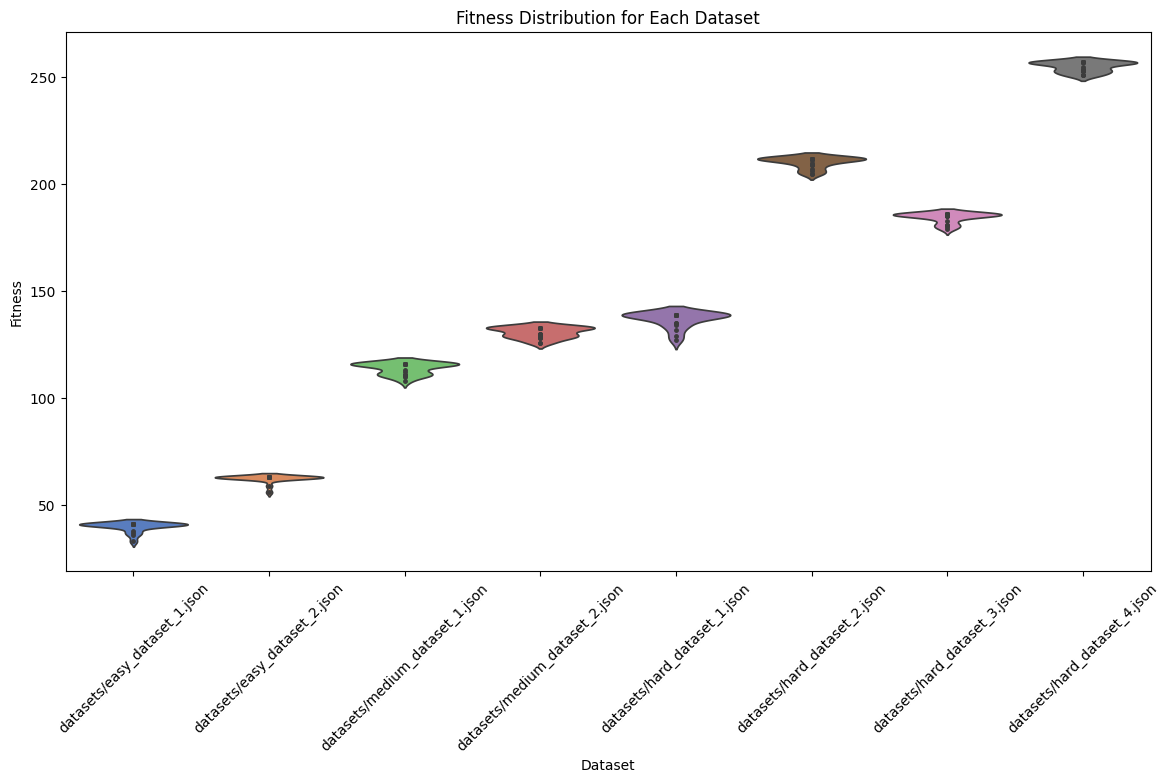

In [44]:
fitness_values = []
dataset_labels = []

for index, row in agents_df.iterrows():
    dataset = row['dataset']
    fitness_list = row['fitness']
    fitness_values.extend(fitness_list)
    dataset_labels.extend([dataset] * len(fitness_list))

plot_data = pd.DataFrame({
    'Dataset': dataset_labels,
    'Fitness': fitness_values
})

plt.figure(figsize=(14, 7))

sns.violinplot(x='Dataset', y='Fitness', data=plot_data, inner='point', palette='muted')

plt.xlabel('Dataset')
plt.ylabel('Fitness')
plt.title('Fitness Distribution for Each Dataset')
plt.xticks(rotation=45)
plt.show()

#### Next point of interest was to study different generations within the algorithm to see the evolution of solutions the algorithm produces.

Again we included this three configurations:
- seletcion method: **torurnament**, crossover method: **one-point**, mutation method: **swap**
- selection method: **ranked-based**, crossover method: **two-point**, mutation method: **scramble**
- selection method: **tournament**, crossover method: **uniform**, mutation method: **inversion**

And we used a **Hard** data set (hard_dataset_2.json)

This is the setup:

In [45]:
configurations = [
    ('tournament', 'one-point', 'random'),
    ('tournament', 'two-point', 'scramble'),
    ('tournament', 'uniform', 'inversion')
]

per_generation_results = []
hardest = 'datasets/hard_dataset_2.json'
N, K, R, min_reviews, max_reviews, preference_matrix, friendship_matrix, authorship_matrix = load_and_parse_data(dataset_path)

for configuration in configurations:

    selection_method, crossover_method, mutation_method = configuration
    print(f"Evaluating configuration: {selection_method}, {crossover_method}, {mutation_method}")

    _, fitness_scores, _ = genetic_algorithm(
        num_papers=N, 
        num_reviewers=K, 
        reviewer_capacity=R, 
        min_reviews=min_reviews_per_paper, 
        max_reviews=max_reviews_per_paper, 
        preference_matrix=preference_matrix,
        friendship_matrix=friendship_matrix,
        authorship_matrix=authorship_matrix,
        generations=1000,
        pop_size=20,
        parents_mating=2,
        selection_method=selection_method,
        crossover_method=crossover_method,
        mutation_method=mutation_method
    )

    for generation, fitness in enumerate(fitness_scores):
        per_generation_results.append({
            'generation': generation,
            'selection_method': selection_method,
            'crossover_method': crossover_method,
            'mutation_method': mutation_method,
            'fitness': fitness
        })

per_generation_results_df = pd.DataFrame(per_generation_results)
print(per_generation_results_df)

Evaluating configuration: tournament, one-point, random
Evaluating configuration: tournament, two-point, scramble
Evaluating configuration: tournament, uniform, inversion
      generation selection_method crossover_method mutation_method  fitness
0              0       tournament        one-point          random      -42
1              1       tournament        one-point          random      -23
2              2       tournament        one-point          random      -19
3              3       tournament        one-point          random      -13
4              4       tournament        one-point          random        3
...          ...              ...              ...             ...      ...
2995         995       tournament          uniform       inversion      278
2996         996       tournament          uniform       inversion      278
2997         997       tournament          uniform       inversion      278
2998         998       tournament          uniform       inversion   

Firsty we used a lineplot to show the progress of fitness scores per generation for different configurations:

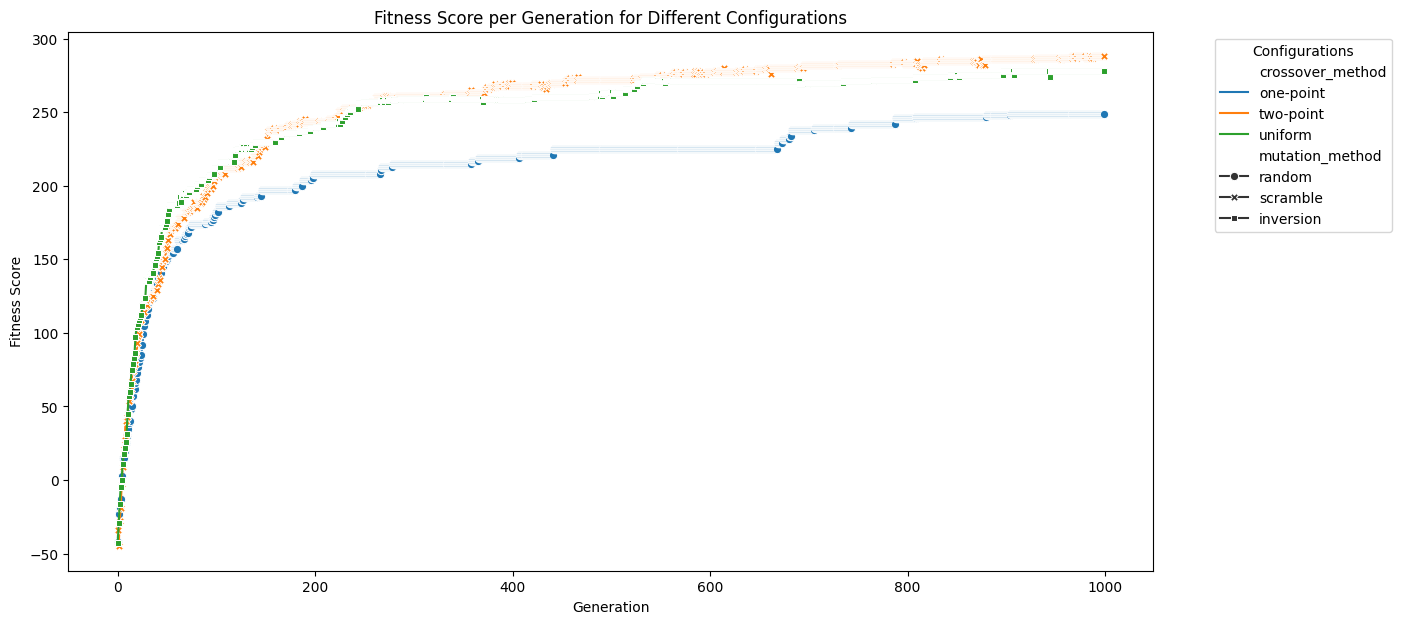

In [46]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=per_generation_results_df, x='generation', y='fitness', hue='crossover_method', style='mutation_method', markers=True, dashes=False)
plt.title('Fitness Score per Generation for Different Configurations')
plt.xlabel('Generation')
plt.ylabel('Fitness Score')
plt.legend(title='Configurations', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

And we can se the average grouth of fitness sore of each generation is:

In [83]:
group_size = 1000
groups = [per_generation_results_df['fitness'].iloc[i:i + group_size] for i in range(0, len(per_generation_results_df), group_size)]
mean_diffs = []

for group in groups:
    diff = group.diff().dropna()
    mean_diff = diff.mean()
    mean_diffs.append(mean_diff)

for configuration, mean_diff in zip(configurations, mean_diffs):
    print(f"The average fitness difference between generations for configuration: {configuration} is {mean_diff}")

The average fitness difference between generations for configuration: ('tournament', 'one-point', 'swap') is 0.2912912912912913
The average fitness difference between generations for configuration: ('rank-based', 'two-point', 'scramble') is 0.32232232232232233
The average fitness difference between generations for configuration: ('tournament', 'uniform', 'inversion') is 0.3213213213213213


As we can see, for each generation the fitness score rises, which is good, because that means that each generation produces better solutions to the problem. Firstly the fitness score rises a lot and later in the generations, the difference falls.

In the next step we used only one configuration:
- selection method: **tournament**, crossover method: **two-point**, mutation method: **scramble**

But we were intrested in the **difference between datasets**.

This is the set up:

In [47]:
dataset_per_gen = []

for dataset_path in dataset_paths:
    N, K, R, min_reviews, max_reviews, preference_matrix, friendship_matrix, authorship_matrix = load_and_parse_data(dataset_path)
       
    best_assignment, fitness_scores, _ = genetic_algorithm(
        num_papers=N, 
        num_reviewers=K, 
        reviewer_capacity=R, 
        min_reviews=min_reviews, 
        max_reviews=max_reviews, 
        preference_matrix=preference_matrix,
        friendship_matrix=friendship_matrix,
        authorship_matrix=authorship_matrix,
        generations=1000,
        pop_size=20,
        parents_mating=2,
        selection_method='tournament',
        crossover_method='two-point',
        mutation_method='scramble'
    )
    best_fitness = max(fitness_scores)
        
    dataset_per_gen.append({
        'dataset': dataset_path,
        'generations': fitness_scores
    })

dataset_per_gen_df = pd.DataFrame(dataset_per_gen)

print(dataset_per_gen_df)


                          dataset  \
0    datasets/easy_dataset_1.json   
1    datasets/easy_dataset_2.json   
2  datasets/medium_dataset_1.json   
3  datasets/medium_dataset_2.json   
4    datasets/hard_dataset_1.json   
5    datasets/hard_dataset_2.json   
6    datasets/hard_dataset_3.json   
7    datasets/hard_dataset_4.json   

                                         generations  
0  [24, 27, 33, 36, 36, 36, 40, 40, 40, 40, 40, 4...  
1  [26, 34, 41, 43, 48, 47, 52, 53, 54, 55, 55, 5...  
2  [42, 46, 55, 53, 58, 61, 65, 66, 70, 71, 72, 7...  
3  [61, 70, 72, 76, 76, 80, 79, 81, 85, 85, 87, 9...  
4  [30, 23, 38, 43, 44, 56, 67, 67, 70, 69, 69, 7...  
5  [115, 117, 127, 130, 141, 147, 152, 154, 156, ...  
6  [-9, -5, 14, 25, 36, 44, 49, 55, 62, 63, 67, 7...  
7  [-43, -44, -22, -13, -10, 5, 12, 17, 22, 29, 3...  


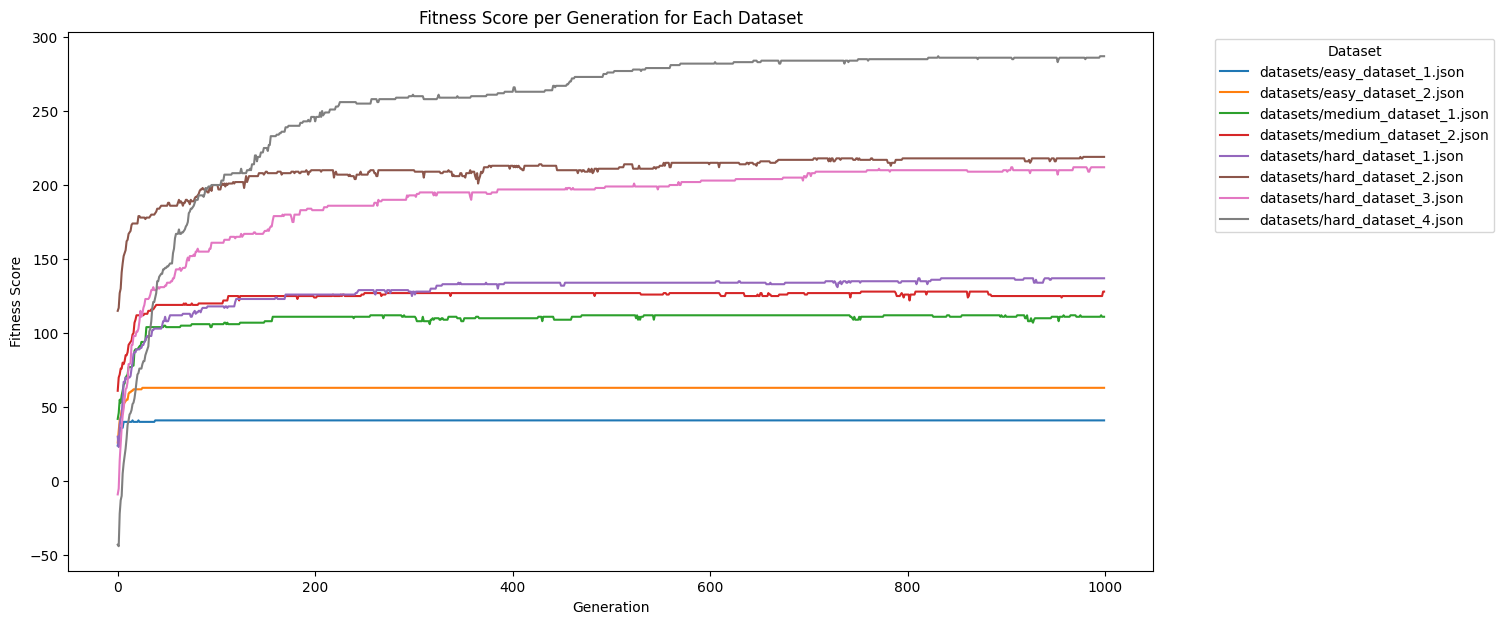

In [48]:
plt.figure(figsize=(14, 7))

for index, row in dataset_per_gen_df.iterrows():
    dataset = row['dataset']
    generations = row['generations']
    plt.plot(generations, label=dataset)

plt.xlabel('Generation')
plt.ylabel('Fitness Score')
plt.title('Fitness Score per Generation for Each Dataset')
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

As we can see, the fitness scores of different generations all act the same even if we change the dataset. First they all rize really quickly and than start to become stable and constant.

#### To conclude our seminary
We think that the genetic algorthm is a really handy invention. It can easly solve complex problems, which humans take really long time to solve. Sometimes the setup of the algorithm could be complex and take time but once the algorithm is ready, it makes our lifes much easyer. For example, the algorithm could be usefull in a company to set up tasks for a big project that takes a long time to make. Ofcourse each reviewer has a different schedule, different holidays, different time of arival and the algorithm could take each of those constrains and build the best plan for the conference to maximize the efficiency.